# <center>Time Series with Long Short Term Memory(LSTM) 
# <center>Recurrent Neural Network

<br>

In this part we will try to build and train Long Short Term Memory Recurrent Neural Network for our time series data. Let's first take a brief overview of LSTM.<br>

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video).<br>

Instead of neurons, LSTM networks have memory blocks that are connected through layers.
### Why LSTM for Time Series?
LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the exploding and vanishing gradient problems that can be encountered when training traditional RNNs.
<br><br>
We will use Keras with Tensorflow at backend for building our Neural Network.

## Importing the Required Libraries

In [1]:
# import necessary files
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error,  mean_absolute_error
import os

In [2]:
cd /content/drive/MyDrive/MLESS Project

/content/drive/MyDrive/MLESS Project


### Single LSTM Neuron architecture

<img src= "https://www.researchgate.net/profile/Xuan_Hien_Le2/publication/334268507/figure/fig8/AS:788364231987201@1564972088814/The-structure-of-the-Long-Short-Term-Memory-LSTM-neural-network-Reproduced-from-Yan.png" height="400" width="700">

#### Designing the Architecture of  LSTM neural network

In [3]:
# Let's design the Architecture of our LSTM neural network
def fit_LSTM(scaled_train_data, time_steps, n_features, batch_size = 8, activation = 'relu', epochs = 10):
    ''''
        train_data: train data for training the model
        test_data: test data for evaluating the model
        activation: activation function. Default is 'relu'.
        return: lstm model

        Note:
        1) time_steps: 12 for monthly, 365 for daily data is preffered.
        2) batch size: let's keep batch size to any fixed size. We will fix it at 8.
    
    '''
    # define generator object to produce batches for training/validation.
    generator = TimeseriesGenerator(data = scaled_train_data, targets = scaled_train_data, length = time_steps, batch_size = batch_size)

    # Since we want to build LSTM network, In Keras we can simply stack multiple layers on top of each other,
    # for this we need to initialize the model as Sequential().
    model = Sequential()

    # add input layer. 
    #           units: We can take units as any no of dimensions(positive) for the outer space.
    #           activation: softmax, relu, softsign etc.
    model.add(LSTM(units = 256, activation = activation, input_shape = (time_steps, n_features),return_sequences=True))

    # Dropout: Every LSTM layer should be accompanied by a Dropout layer.
    #          20% is often used as a good compromise between retaining model accuracy
    #          and preventing overfitting.
    model.add(Dropout(0.2))

    model.add(LSTM(units = 128, activation = activation, input_shape = (time_steps, n_features),return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(16))
    # add output layer the model. Since our model is making 
    # single predictions we'll take output layer as 1.
    model.add(Dense(1))
    # compile the model. Generally we use 'adam' optimiser. Let's take loss as mean square error. 
    model.compile(optimizer='adam', loss='mse')
    # fit the lstm neural network
    model.fit_generator(generator, epochs = epochs)
    
    return model

In [4]:
# function for predicting data for LSTM
def predict_LSTM(scaled_train_data, scaler, train_data, test_data, time_steps, n_features, lstm_model):
    '''
        scaled_train_data: scaled train data.
        scaler: MinMaxScaler object for inverting transformations.
        scaled_test_data:  scaled test data.
        train_data:  train data.
        test_data:   test data.
        time_steps: Time steps
        n_features: Number of units in one input sequence.
        lstm_model: The LSTM model to evaluate.
        return : Predicted values.
    '''
    # for storing predicted values.
    pred_list = []
    batch = scaled_train_data[-time_steps:].reshape(1, time_steps, n_features)
    for i in range(time_steps):
        pred_list.append(lstm_model.predict(batch)[0])
        batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis = 1)
    # creating dataframe of predicted values
    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=test_data.index, columns = ['Predictions'])
    # plotting the results
    plt.figure(figsize = (20, 5))
    plt.plot(train_data.index, train_data, label = 'Train')
    plt.plot(test_data.index, test_data, label = 'Test')
    plt.plot(df_predict.index, df_predict, label = 'Prediction')
    plt.legend(loc='best', fontsize='xx-large')
    # print pollutant name
    print('\nPredictions of ',train_data.columns.values[0])
    plt.show()
    
    return df_predict

In [12]:
# function for evaluating the model
def evaluate_LSTM(actual, predicted, file_path_and_name):
    '''
        actual: actual values
        predicted: predicted values
        return: None
        
        calculates Mean square Error, Mean Absolute error and Root Mean Square Error
        
    '''
    # print pollutant name
    print('\nEvaluation of ',actual.columns.values[0])
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print('The Mean Squared Error of the forecasts is {}'.format(round(mse, 4)))
    print('The Mean Absolute Error of the forecasts is {}'.format(round(mae, 4)))
    print('The Root Mean Squared Error of the forecasts is {}'.format(round(rmse,4)))
    
    # save results locally
    if not os.path.exists('predictions'): os.mkdir('predictions')
    if not os.path.exists(file_path_and_name):
        # create result dataframe for storing evaluation results(initialized with zeros)
        pd.DataFrame(data = {'EM' : ['mse','mae','rmse'] , 'PM2.5': [0.0,0.0,0.0], 'PM10': [0.0,0.0,0.0],
                                  'SO2': [0.0,0.0,0.0], 'NO2': [0.0,0.0,0.0],
                                  'CO': [0.0,0.0,0.0], 'O3': [0.0,0.0,0.0],


                            }).to_csv(file_path_and_name,index = False)
        
    # read the lstm.csv file
    result = pd.read_csv(file_path_and_name, dtype = {'EM':str})
    # set index as EM (Evaluation Matrix)
    result.set_index('EM', inplace = True)
    # write all the results
    result[actual.columns.values[0]]['mse'] = round(mse, 4)
    result[actual.columns.values[0]]['mae'] = round(mae, 4)
    result[actual.columns.values[0]]['rmse'] = round(rmse, 4)
    # save the file after writing
    result.to_csv(file_path_and_name)
    # display successfull write message
    print('\nResults for {} successfully saved to {}'.format(actual.columns.values[0],file_path_and_name))

In [6]:
# Scaling Train-Test data
def transform_data(train_data):
    '''
        train_data: Train data
        test_data: Test data
        return: (scaled_train_data, scaler)
    '''
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    
    return scaler.transform(train_data), scaler 

#### Applying LSTM to daily data of PM2.5
Let's first apply our LSTM model to daily data of PM2.5.

In [7]:
# loading the daily data of PM2.5
train_PM25 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/daily/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/daily/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])

In order to feed our data into the neural network We need to first format our data into the specific format. Usually we scale data between either between (0,1) or (-1,1). We will use MinMaxScaler of scikitlearn library which will automatically scale the data.

In [8]:
# transform train_PM25 data
scaled_train_PM25, scaler = transform_data(train_PM25)

In [9]:
# define parameters for the LSTM model
# time_steps: 12 for monthly, 365 for daily data is preffered.
time_steps = 365
# no of units as n_feature: Since we have only one feature so we will take n_feature as 1.
n_feature = 1
# fit the LSTM model
model = fit_LSTM(scaled_train_PM25, time_steps, n_feature)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
92/92 [==============================] - 132s 1s/step - loss: 0.0179
Epoch 2/10
92/92 [==============================] - 119s 1s/step - loss: 0.0170
Epoch 3/10
92/92 [==============================] - 118s 1s/step - loss: 0.0165
Epoch 4/10
92/92 [==============================] - 118s 1s/step - loss: 0.0163
Epoch 5/10
92/92 [==============================] - 121s 1s/step - loss: 0.0161
Epoch 6/10
92/92 [==============================] - 116s 1s/step - loss: 0.0161
Epoch 7/10
92/92 [==============================] - 120s 1s/step - loss: 0.0158
Epoch 8/10
92/92 [==============================] - 120s 1s/step - loss: 0.0153
Epoch 9/10
92/92 [==============================] - 118s 1s/step - loss: 0.0156
Epoch 10/10
92/92 [==============================] - 117s 1s/step - loss: 0.0142



Predictions of  PM2.5


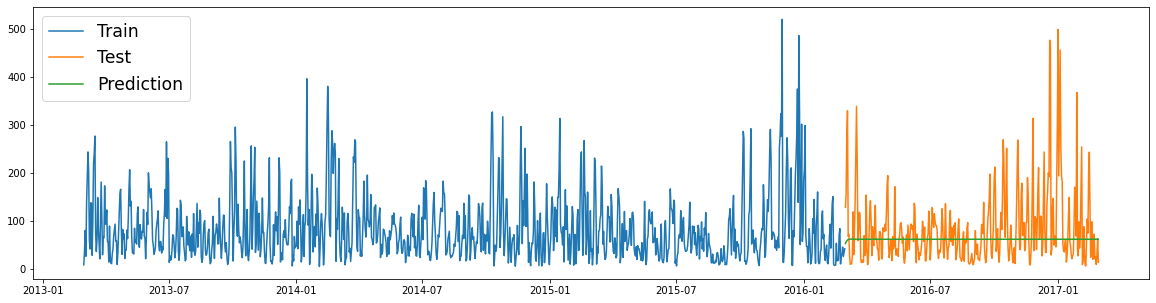

In [10]:
# Predict PM2.5 using LSTM
predictions = predict_LSTM(scaled_train_PM25, scaler, train_PM25, test_PM25,time_steps, n_feature, model)

In [13]:
# Plot the predictions for PM2.5 pollutant
evaluate_LSTM(test_PM25, predictions,"/content/drive/MyDrive/MLESS Project/predictions/Gucheng/daily/lstm_PM2_5.csv")


Evaluation of  PM2.5
The Mean Squared Error of the forecasts is 6324.4737
The Mean Absolute Error of the forecasts is 49.9025
The Root Mean Squared Error of the forecasts is 79.5266

Results for PM2.5 successfully saved to /content/drive/MyDrive/MLESS Project/predictions/Gucheng/daily/lstm_PM2_5.csv


It's look like our model is having a hard time fitting the daily data. Hyperparameter Tuning is required. Since the daily data is quite large, Hyperparameter Tuning will take a lot of time. So due to Time constraints let's move on monthly data.

#### Applying LSTM model on all the monthly pollutants data

In [14]:
# load all monthly datasets
train_PM25 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])
train_PM10 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/train/train_PM10.csv', parse_dates = [0], index_col = [0])
test_PM10 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/test/test_PM10.csv', parse_dates = [0], index_col = [0])
train_SO2 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/train/train_SO2.csv', parse_dates = [0], index_col = [0])
test_SO2 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/test/test_SO2.csv', parse_dates = [0], index_col = [0])
train_NO2 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/train/train_NO2.csv', parse_dates = [0], index_col = [0])
test_NO2 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/test/test_NO2.csv', parse_dates = [0], index_col = [0])
train_CO = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/train/train_CO.csv', parse_dates = [0], index_col = [0])
test_CO = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/test/test_CO.csv', parse_dates = [0], index_col = [0])
train_O3 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/train/train_O3.csv', parse_dates = [0], index_col = [0])
test_O3 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/test/test_O3.csv', parse_dates = [0], index_col = [0])

In [15]:
# apply transformations on all monthly data
scaled_train_PM25, scaler_PM25 = transform_data(train_PM25)
scaled_train_PM10, scaler_PM10 = transform_data(train_PM10)
scaled_train_SO2, scaler_SO2 = transform_data(train_SO2)
scaled_train_NO2, scaler_NO2 = transform_data(train_NO2)
scaled_train_CO, scaler_CO = transform_data(train_CO)
scaled_train_O3, scaler_O3 = transform_data(train_O3)

In [16]:
# define parameters for the LSTM model (After some manual hyperparameter tuning)
# time_steps: 12 for monthly, 365 for daily data is preffered.
time_steps = 12
# no of units as n_feature: Since we have only one feature so we will take n_feature as 1.
n_feature = 1
# set epochs to 350
epochs = 350
# create list for test data
list_test = [test_PM25, test_PM10, test_SO2, test_NO2, test_CO, test_O3]
# create list for train data
list_train = [train_PM25, train_PM10, train_SO2, train_NO2, train_CO, train_O3]
# create list for scaled train data
list_scaled_train = [scaled_train_PM25, scaled_train_PM10, scaled_train_SO2, scaled_train_NO2, scaled_train_CO, scaled_train_O3]
# create list of all scalers
list_scaler = [scaler_PM25, scaler_PM10, scaler_SO2, scaler_NO2, scaler_CO, scaler_O3]
# create list for storing models
list_models = []
# fit LSTM model to all the data
for i in range(len(list_scaled_train)):
    print('\nFitting LSTM on ',list_train[i].columns.values[0])
    list_models.append(fit_LSTM(list_scaled_train[i], time_steps, n_feature, epochs = epochs))


Fitting LSTM on  PM2.5
Epoch 1/350


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


3/3 [==============================] - 2s 44ms/step - loss: 0.1017
Epoch 2/350
3/3 [==============================] - 0s 78ms/step - loss: 0.0542
Epoch 3/350
3/3 [==============================] - 0s 60ms/step - loss: 0.0597
Epoch 4/350
3/3 [==============================] - 0s 43ms/step - loss: 0.0510
Epoch 5/350
3/3 [==============================] - 0s 55ms/step - loss: 0.0520
Epoch 6/350
3/3 [==============================] - 0s 54ms/step - loss: 0.0503
Epoch 7/350
3/3 [==============================] - 0s 69ms/step - loss: 0.0475
Epoch 8/350
3/3 [==============================] - 0s 59ms/step - loss: 0.0469
Epoch 9/350
3/3 [==============================] - 0s 70ms/step - loss: 0.0539
Epoch 10/350
3/3 [==============================] - 0s 48ms/step - loss: 0.0460
Epoch 11/350
3/3 [==============================] - 0s 47ms/step - loss: 0.0473
Epoch 12/350
3/3 [==============================] - 0s 58ms/step - loss: 0.0417
Epoch 13/350
3/3 [==============================] - 0s 50ms/s


Predictions of  PM2.5


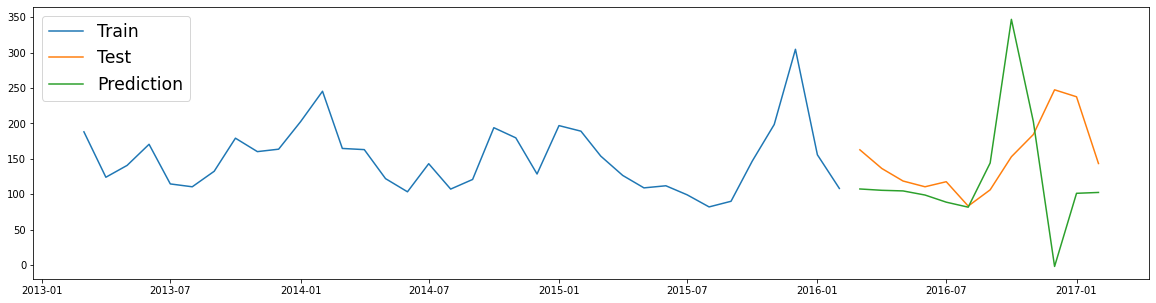


Predictions of  PM10


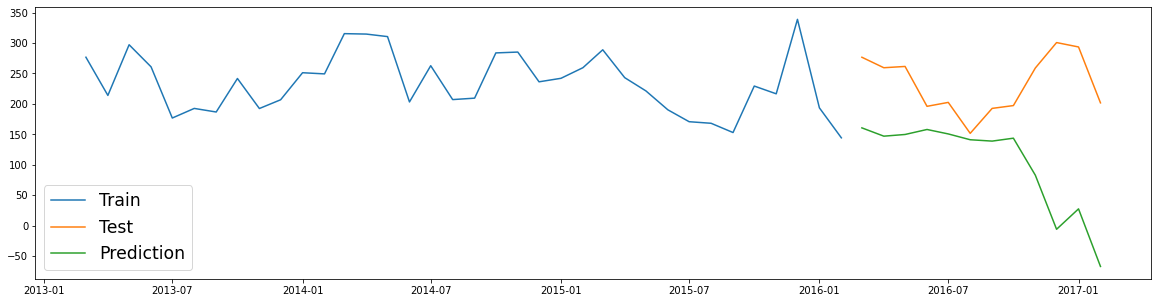


Predictions of  SO2


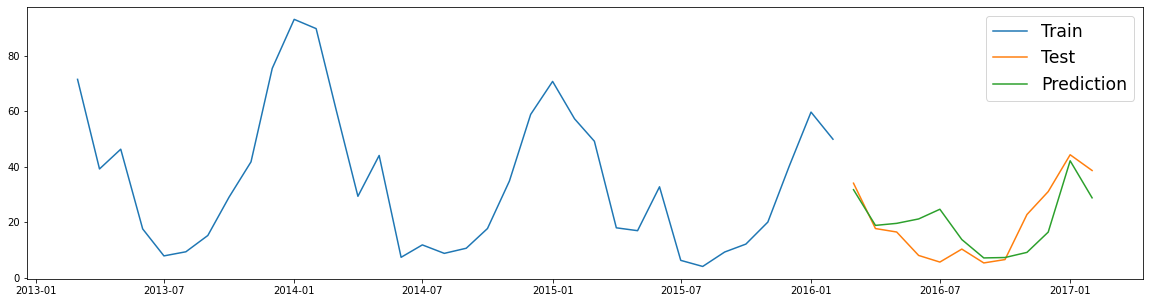


Predictions of  NO2


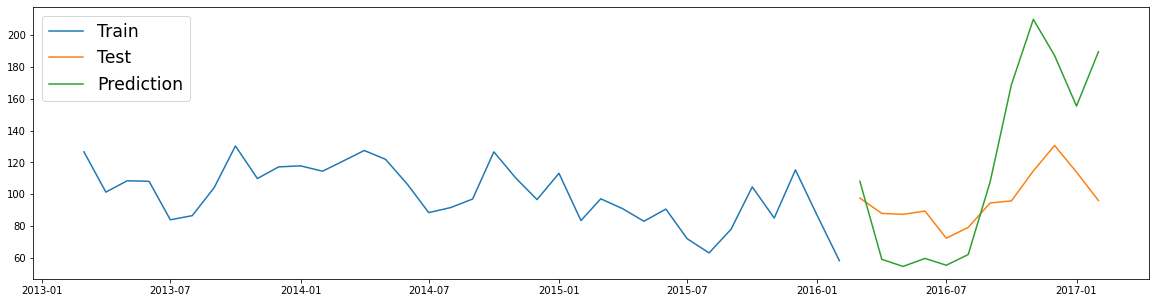


Predictions of  CO


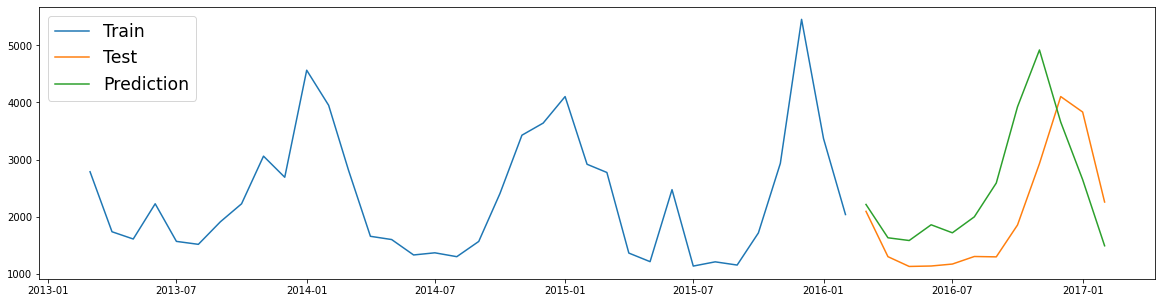


Predictions of  O3


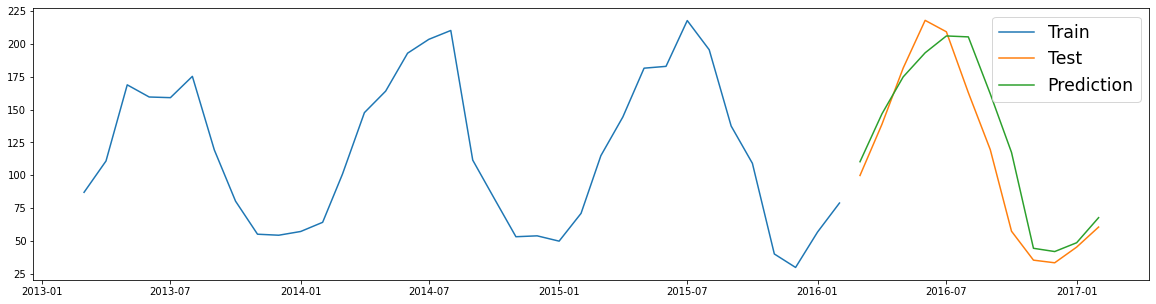

In [17]:
# Predict all the pollutants
list_predictions = [predict_LSTM(list_scaled_train[i], list_scaler[i],list_train[i], list_test[i],time_steps,n_feature, list_models[i]) for i in range(len(list_scaled_train))]


In [18]:
list_file_path_and_names = ["/content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/lstm_PM25.csv",
                            "/content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/lstm_PM10.csv",
                            "/content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/lstm_SO2.csv",
                            "/content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/lstm_NO2.csv",
                            "/content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/lstm_CO.csv",
                            "/content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/lstm_O3.csv",]

In [19]:
# Evaluate all the models
for i,j in zip(range(len(list_predictions)), list_file_path_and_names):
    # Evaluate each model
    evaluate_LSTM(list_test[i], list_predictions[i],j)


Evaluation of  PM2.5
The Mean Squared Error of the forecasts is 10604.0094
The Mean Absolute Error of the forecasts is 68.3021
The Root Mean Squared Error of the forecasts is 102.9758

Results for PM2.5 successfully saved to /content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/lstm_PM25.csv

Evaluation of  PM10
The Mean Squared Error of the forecasts is 26424.2585
The Mean Absolute Error of the forecasts is 130.5437
The Root Mean Squared Error of the forecasts is 162.5554

Results for PM10 successfully saved to /content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/lstm_PM10.csv

Evaluation of  SO2
The Mean Squared Error of the forecasts is 89.2242
The Mean Absolute Error of the forecasts is 7.0942
The Root Mean Squared Error of the forecasts is 9.4459

Results for SO2 successfully saved to /content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/lstm_SO2.csv

Evaluation of  NO2
The Mean Squared Error of the forecasts is 2646.5968
The Mean Absolute Error 

As we can see from the results, our model fit well only for CO, O3 and SO2.<br>
***Note: We can still improver the model performance by Hyperparameter Tuning. But due to Time and compute contraints we will skip Hyperparameter Tuning part.***